In [1]:
import mne
import os
import scipy.io
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
from itertools import permutations,combinations
from IPython.display import clear_output
import seaborn as sns
from scipy.linalg import toeplitz
from numpy import linalg as LA
from mne.event import define_target_events

data_path = os.path.dirname(os.path.dirname(os.getcwd()))


save_path = data_path + '/python/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


Opening raw data file D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


In [43]:
# data preprocessing parameters


new_sampling_rate = 100

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop']


con = ['hyper','normal','hypo','All']
con = 'All'

delay = np.arange(-5,5.5,0.5) / 10
delay = [0]


In [5]:
# cca parameters


# CCA functions
def nanRXY(X,Y):
    D = X.shape[0]
    x = np.vstack([X,Y])
    RXY = np.cov(x)
    
    Rxx = RXY[0:D,0:D]
    Ryy = RXY[D:,D:]
    Rxy = RXY[0:D,D:]
    Ryx = RXY[D:,0:D]
    return Rxx,Ryy,Rxy,Ryx
    
def regInv(R,K,typeF):
    
    eigenValues,eigenVectors = LA.eigh(R)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    if(typeF=='sqrt'):
        d = 1/np.sqrt(eigenValues[-K:])  # regularized sqrt inverse
    else:
        d = 1/eigenValues[-K:]           #regularized inverse

    d = np.diag(d)   
    SqrtInvR= np.dot(eigenVectors[:,-K:], (np.dot( d, eigenVectors[:,-K:].T)))

    return SqrtInvR

def myCannoncorr(X,Y,Kx,Ky):
    Rxx,Ryy,Rxy,Ryx = nanRXY(X,Y)    

    # compute A
    Rxxnsq = regInv(Rxx,Kx,'sqrt'); # regularized Rxx^(-1/2)
    Ryyn = regInv(Ryy,Ky,'x')

    M = Rxxnsq.dot(Rxy).dot(Ryyn).dot(Ryx).dot(Rxxnsq)
    M = np.sum([M,M.T],axis=0) / 2   # fix nummerical precision asymmetric

    eigenValues,eigenVectors = LA.eigh(M)
    idx = np.argsort(eigenValues)
    #idx = idx[::-1]

    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    d = eigenVectors[:,-np.min((Kx,Ky)):]    
    A = Rxxnsq.dot(d)    # invert coordinate transformation


    # compute B
    Ryynsq=regInv(Ryy,Ky,'sqrt') # regularized Ryy^(-1/2)
    D=Ryynsq.dot(Ryx).dot(Rxxnsq).dot(d)
    B=Ryynsq.dot(D)


    U=A.T.dot(X)
    V=B.T.dot(Y)
    
    
    nVars= np.min((U.shape[0],V.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(U[i,:],V[i,:])
        rhos[i] = r
        pvals[i] = p
    
    
    return A,B,rhos,pvals,U,V,Rxx,Ryy




#the temporal aperture -- how long to filter the kinematic signals (i.e., 1 second)
temporal_aperature = 100


Kx = 10    
Ky = 5
nComp=5


# data selection two ways 
1) use same amount of data common to all trials (here 2sec) <br>
2) use all trial length (longer trial will have more contribution)<br>
3) use same amount of data common to all trials (here 2sec) concat all the subjects in one delay

In [7]:
# read epoches
Tmin = 0
Tmax = 3.51
trial_len = 2
remove_first = 0.5 #seconds

GA_epoches = []
for s in subject_name:
    save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin)+'-' \
    +str(Tmax)+'-trialLen-'+str(trial_len)+'_normalized.fif'
    a = mne.read_epochs(save_path)
    GA_epoches.append(a)
    
    # save matlab files for yannis matlab analysis
    #save_path = data_path + '/python/matlab_CCA/data/'+s+'.mat'
    #scipy.io.savemat(save_path, {'data':a.get_data(),'label':a.ch_names})

    print('----------------------------------------------------------------------------------------------------------------'+s)
clear_output()

In [8]:
# resample the data to new_sampling_rate

for s in range(0,len(subject_name)):
    GA_epoches[s].resample(new_sampling_rate, npad='auto')


# 1

In [ ]:
# 2sec trial functions

def coherence_preprocess_delay(epochs,remove_first,d,trial_len,extra_channels,eeg_channles,condition):	

    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
        
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(extra_channels)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
        
    return E.get_data(),S.get_data()

def restructure_data(eeg,ema,temporal_aperature):
    eeg = np.hstack(eeg)

    x = np.hstack(ema)
    x = stats.zscore(x, axis=1)
    ema = np.stack(np.split(x, ema.shape[0], axis=1))

    X = []
    for t in range(0,ema.shape[0]):
        a = ema[t,:,:]
        tmp =[]
        for i in range(0,a.shape[0]):
            x = toeplitz(a[i,:])
            y= np.tril(np.ones((x.shape[0], x.shape[0]), dtype=int))
            x = x*y
            tmp.append(x[:,0:temporal_aperature])
        tmp = np.hstack(tmp)   
        X.append(tmp) 

    X = np.vstack(X)
    ema = np.hstack((X,np.ones((X.shape[0],1))))

    return eeg,ema.T


In [12]:
# select data (2sec)

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']


###########################


frame = []
for s in range(0,len(subject_name)):
    for d in delay:
        eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)    
        eeg,ema = restructure_data(eeg,ema,temporal_aperature)
        
        # cca train 
        A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(ema,eeg,Kx,Ky)

        

    
        df = pd.DataFrame({'subject':subject_name[s],'Delay':d,'A':[A],'B':[B],'r':[rhos],
                           'p':[pvals],'U':[U],'V':[V],'Rxx':[Rxx],'Ryy':[Ryy]})
        frame.append(df)
        print(str(d)+'-'+subject_name[s])

    #df = pd.concat((frame),axis=0)
        
        
data_CCA = pd.concat((frame),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_2sec_envelop.pkl'
#save_path = data_path + '/python/data/cca/cca_yannis_2sec'+str(fmin)+'-'+str(fmax)+'.pkl'
data_CCA.to_pickle(save_path)

clear_output()

# 2

In [ ]:
# whole trial functions
def epoch(raw, mat,Tmin, Tmax):
    # ignore stimuli shorter than tmax ms
    events = mne.find_events(raw, stim_channel='Trigger')
    reference_id = 105  # speech onset
    target_id = 106  # speech offset
    sfreq = raw.info['sfreq']  # sampling rate
    tmin = 0  
    new_id = 99  # the new event id for a hit. If None, reference_id is used.
    fill_na = 105  # the fill value for misses
    events_, lag = define_target_events(events, reference_id, target_id,sfreq, tmin, Tmax, new_id, fill_na)
    events_  = np.where(events_[:,2] == 105)[0] +1


    #behaviour (remove the wrong answer trials and seperate the in three conditions)	
    condition= mat['behaviour']['condition'][0]
    response= mat['behaviour']['response'][0]
    a = np.hstack((condition[0],response[0]))

    df = pd.DataFrame({'condition':a[:,0],'response':a[:,1]})
    df.index = df.index + 1

    hyper  = df.loc[(df['condition'] == 1) & (df['response'] == 0)]
    normal = df.loc[(df['condition'] == 2) & (df['response'] == 0)]
    hypo   = df.loc[(df['condition'] == 3) & (df['response'] == 0)]

    events = mne.find_events(raw, stim_channel='trial_no')
    hyper = np.intersect1d(events_, hyper.index.values)
    normal = np.intersect1d(events_, normal.index.values)
    hypo = np.intersect1d(events_, hypo.index.values)

    a = np.concatenate((hyper,normal,hypo),axis=0)
    IDX = np.sort(a, axis=0) -1

    hyper = events[hyper-1]
    hyper[:,2] = 1
    normal = events[normal-1]
    normal[:,2] = 2
    hypo = events[hypo-1]
    hypo[:,2] = 3
    a = np.vstack((hyper,normal,hypo))
    events = np.sort(a, axis=0)
    
    ##########
    
    #add EMA, envelop signal as extra channels
    extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    envelop = mat['behaviour']['envelop'][0][0]
    jawaopening = mat['behaviour']['jawaopening'][0][0]
    lipaparature = mat['behaviour']['lipaparature'][0][0]
    lipProtrusion = mat['behaviour']['lipProtrusion'][0][0]
    TTCD = mat['behaviour']['TTCD'][0][0]
    TMCD = mat['behaviour']['TMCD'][0][0]
    TBCD = mat['behaviour']['TBCD'][0][0]
    A = []
    for i in range(0,len(IDX)):
        a = np.vstack((envelop[IDX[i]][0],jawaopening[IDX[i]][0].T,lipaparature[IDX[i]][0].T,lipProtrusion[IDX[i]][0].T,
                       TTCD[IDX[i]][0].T,TMCD[IDX[i]][0].T,TBCD[IDX[i]][0].T))
        A.append(a)
    
    return events,A

def restructure_data(raw,events,EMA):
    
    events_ = mne.find_events(raw, stim_channel='Trigger')
    a = events_[np.where(events_[:,2] == 105)[0],0]
    b = events_[np.where(events_[:,2] == 106)[0],0]

    c = np.in1d(a,events[:,0])
    a = a[c] - raw.first_samp
    b = b[c] - raw.first_samp

    A = raw.get_data()
    B=[]
    for i in range(0,len(a)):
        c = signal.decimate(A[0:59,a[i]:b[i]], 10) # decimate to 200 hz 1000/100 =10
        d = signal.decimate(EMA[i], 4) # decimate to 200 hz 400/100 = 4

        #c = A[0:59,a[i]:b[i]]
        #d = EMA[i]
        if(c.shape[1]>d.shape[1]):
            x = np.pad(d,((0,0),(0,c.shape[1]-d.shape[1])), 'constant')
            x = np.vstack((c,x))
        elif(c.shape[1]<d.shape[1]):
            x = np.pad(c,((0,0),(0,d.shape[1]-c.shape[1])), 'constant')
            x = np.vstack((x,d))
        else:
            x = np.vstack((c,d))
        B.append(x)
    clear_output()
    
    x = np.column_stack(B)
    eeg = x[0:59,:]
    ema = x[60:66,:]
    return B

def restructure_data2(eeg,ema,temporal_aperature,L,features):
    
    aa = np.hstack(ema)
    aa = stats.zscore(aa, axis=1)
    if(features=='envelop'):
        aa = aa[0,:]
    else:
        aa = aa[1:,:]
    mark_bad_trial = []
    X = []
    for t in range(0,len(ema)):
        a = aa[:,0:L[t]]
        #print(a.shape)
        tmp =[]
        for i in range(0,a.shape[0]):
            x = toeplitz(a[i,:])
            y= np.tril(np.ones((x.shape[0], x.shape[0]), dtype=int))
            x = x*y
            tmp.append(x[:,0:temporal_aperature])
        tmp = np.hstack(tmp)

        if(tmp.shape[1]==600):
            X.append(tmp) 
        else:
            mark_bad_trial.append(t)

        aa = aa[:,a.shape[1]:]

    X = np.vstack(X)
    ema = np.hstack((X,np.ones((X.shape[0],1))))
    
    mark_bad_trial = np.asarray(mark_bad_trial)
    new_list = []
    for e in range(0,len(eeg)):
        if not(np.isin(e,mark_bad_trial)):        
            new_list.append(eeg[e])
    eeg = new_list
    eeg = np.hstack(eeg)
    return eeg,ema.T

def get_data(data,remove_first,d,sfreq):
    
    rs = 0.5*sfreq
    dd = d*sfreq
    L = []
    trial_no = len(data)
    eeg=[]
    ema=[]
    for tr in range(0,trial_no):
        #print(data[tr].shape[1])

        aa = data[tr][:,int((remove_first)*sfreq):]
        
        
        trial_len = aa.shape[1] - 1*sfreq

        start_i = round(dd)
        end_i = round(dd+trial_len)

        
        start_s = round(rs)
        end_s = round(rs+trial_len)

        
            
        #print(int(start_i),int(end_i),int(start_s),int(end_s))
        
        E = aa[0:59,int(start_i):int(end_i)]
        S = aa[-7:,int(start_s):int(end_s)]
        
        
        eeg.append(E)
        ema.append(S)
        L.append(S.shape[1])
    return eeg,ema,np.asarray(L)


In [62]:
# whole trial

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop']


###########################

frame = []
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,EMA = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,EMA)
    
    for d in delay:
        
        eeg,ema,L = get_data(A_sub,remove_first,d+0.5,sfreq)
        eeg,ema = restructure_data2(eeg,ema,temporal_aperature,L,features)
        
        # cca train 
        A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(ema,eeg,Kx,Ky)

        df = pd.DataFrame({'subject':subject_name[s],'Delay':d,'A':[A],'B':[B],'r':[rhos],
                           'p':[pvals],'U':[U],'V':[V],'Rxx':[Rxx],'Ryy':[Ryy]})
        frame.append(df)
        print(str(d)+'-'+subject_name[s])

    #df = pd.concat((frame),axis=0)
        
        
data_CCA = pd.concat((frame),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_alltrial_envelop.pkl'
#save_path = data_path + '/python/data/cca/cca_yannis_2sec'+str(fmin)+'-'+str(fmax)+'.pkl'
data_CCA.to_pickle(save_path)
clear_output()

# 3

In [35]:
# select data (2sec) concat all the subjects in one delay

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

###########################

frame = []
EEG = []
EMA = []
for s in range(0,len(subject_name)):
    for d in delay:
        eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)    
        eeg,ema = restructure_data(eeg,ema,temporal_aperature)
        EEG.append(eeg)
        EMA.append(ema)
        frame.append(eeg.shape[1])
        
EEG = np.hstack(EEG)    
EMA = np.hstack(EMA)     


# cca train 
A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)

X=[]
for s in range(0,len(subject_name)):
    if(s==0):
        u=U[:,0:frame[s]]
        v=V[:,0:frame[s]]
    else:
        u=U[:,frame[s-1]:frame[s-1]+frame[s]]
        v=V[:,frame[s-1]:frame[s-1]+frame[s]]

    nVars= np.min((u.shape[0],v.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(u[i,:],v[i,:])
        rhos[i] = r
        pvals[i] = p
        
    df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                   'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})
    
    X.append(df)
    print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_2sec_envelop_concatALLsub_0delay.pkl'
data_CCA.to_pickle(save_path)
clear_output()

ValueError: arrays must all be same length

In [ ]:
# whole trial concat all the subjects in one delay
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop']

frame = []
EEG = []
EMA = []
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,a = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,a)
    eeg,ema,L = get_data(A_sub,remove_first,d+0.5,sfreq)
    eeg,ema = restructure_data2(eeg,ema,temporal_aperature,L,features)
    EEG.append(eeg)
    EMA.append(ema)
    frame.append(eeg.shape[1])
        
EEG = np.hstack(EEG)    
EMA = np.hstack(EMA)     


# cca train 
A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)

X=[]
for s in range(0,len(subject_name)):
    if(s==0):
        u=U[:,0:frame[s]]
        v=V[:,0:frame[s]]
    else:
        u=U[:,frame[s-1]:frame[s-1]+frame[s]]
        v=V[:,frame[s-1]:frame[s-1]+frame[s]]

    nVars= np.min((u.shape[0],v.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(u[i,:],v[i,:])
        rhos[i] = r
        pvals[i] = p
        
    df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                   'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})
    
    X.append(df)
    print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_wholetrial_envelop_concatALLsub_0delay.pkl'
data_CCA.to_pickle(save_path)

clear_output()

# CCA Analysis

# choosing CCA regularization parameters Kx and Ky (skip this section if already choosen)

different values of them affect the results.They should not affect the extracted components very much but they usually affect the correlation values. One good way for selecting values for these parameters is to to svd to your input matrices EEG and KIN and plot the variance accounted for curve as a function of the number of eigenvalues. You then look for a "knee" or saturation point in the curve and choose as many svd dimensions (Kx and Ky).


In [ ]:
# choosing the kx by svd [eeg]

eeg,ema,L = get_data(A_sub,remove_first,d+0.5,sfreq)
eeg,ema = restructure_data2(eeg,ema,temporal_aperature,L)
u,s,vh=LA.svd(eeg)

# plot the eigen values and choose the knee saturation point
plt.plot(s)

# its 5 here

In [ ]:
# choosing the ky by svd [ema]
u1,s1,vh1=LA.svd(ema)
plt.plot(s1)


# load data

In [45]:
# load data (2sec, whole trial)
save_path = data_path + '/python/data/cca/cca_yannis_2sec_concatALLsub_0delay.pkl'
save_path = data_path + '/python/data/cca/cca_yannis_wholetrial_concatALLsub_0delay.pkl'
save_path = data_path + '/python/data/cca/cca_yannis_2sec.pkl'
save_path = data_path + '/python/data/cca/cca_yannis_alltrial.pkl'
save_path = data_path + '/python/data/cca/cca_yannis_2sec_envelop.pkl'
save_path = data_path + '/python/data/cca/cca_yannis_2sec_envelop_concatALLsub_0delay.pkl'


data_CCA = pd.read_pickle(save_path)


In [46]:
# arrange data
def get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate):   
    b = B[:,0:nComp]/LA.norm(B[:,0:nComp])
    forwards = Ryy.dot(b).dot(LA.inv(b.T.dot(Ryy).dot(b)))  # B are the spatial filters applied to the EEG
    filters = A[:,0:nComp] # A are the filters applied to the kinematics    
    tvec=np.arange((-temporal_aperature/2+1),(temporal_aperature/2)+1)/new_sampling_rate
    
    return forwards,filters, tvec

C = []

for s in range(0,len(subject_name)):
    for d in delay:
        df = data_CCA[(data_CCA['subject']==subject_name[s]) & (data_CCA['Delay']==d)]
        A = df['A'].get_values()[0]
        B = df['B'].get_values()[0]
        Ryy = df['Ryy'].get_values()[0]
        r = df['r'].get_values()[0]
        p = df['p'].get_values()[0]
        forwards,filters, tvec = get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate)
        filters = filters[0:-1,:]
        filters = np.dstack(np.array_split(filters,filters.shape[0]/temporal_aperature,axis=0))

        frame=[]
        a = pd.Series({'subject':subject_name[s],'Delay':d})   
        frame.append(a)
        comp_idx = nComp-1
        for i in range(0,nComp):
            a = pd.Series({'Component'+str(comp_idx)+'_corr':r[i][0],
                           'Component'+str(comp_idx)+'_p':p[i][0],
                           'Component'+str(comp_idx)+'_topo':forwards[:,i],
                          'Component'+str(comp_idx)+'_filters':[filters[:,i,:]]})
            frame.append(a)
            comp_idx = comp_idx-1
        df = pd.concat((frame),axis=0)
        df = pd.DataFrame(df) 
        C.append(df.T)
        
data_plot = pd.concat((C),axis=0)

data_plot.head()

,Delay,subject,Component4_corr,Component4_filters,Component4_p,Component4_topo,Component3_corr,Component3_filters,Component3_p,Component3_topo,...,Component2_p,Component2_topo,Component1_corr,Component1_filters,Component1_p,Component1_topo,Component0_corr,Component0_filters,Component0_p,Component0_topo
0,0,Alice,-0.00455172,"[[[0.005004035838956319], [0.00722122174981602...",0.47241,"[11.177395347374308, 8.33202871952438, 13.6199...",0.00409446,"[[[-0.03855965348623109], [-0.0432517598861943...",0.518036,"[6.099554795469967, 4.81775941790356, 7.708756...",...,0.271836,"[3.9100095532987513, 4.039069859985207, 2.3737...",-0.0139018,"[[[0.033932324064788535], [0.04039573005370142...",0.0281831,"[1.1251413653302542, 1.3793195026009066, 0.788...",0.0729783,"[[[-0.03460098724369152], [-0.037521571925167]...",8.67403e-31,"[0.09128107556223897, -0.07720372245918222, 0...."
0,0,Andrea,-0.00521243,"[[[0.005004035838956319], [0.00722122174981602...",0.410583,"[11.177395347374308, 8.33202871952438, 13.6199...",0.0164668,"[[[-0.03855965348623109], [-0.0432517598861943...",0.00933023,"[6.099554795469967, 4.81775941790356, 7.708756...",...,0.772024,"[3.9100095532987513, 4.039069859985207, 2.3737...",-0.0174103,"[[[0.033932324064788535], [0.04039573005370142...",0.00598321,"[1.1251413653302542, 1.3793195026009066, 0.788...",0.0778556,"[[[-0.03460098724369152], [-0.037521571925167]...",8.063e-35,"[0.09128107556223897, -0.07720372245918222, 0...."
0,0,Daniel,-0.00521243,"[[[0.005004035838956319], [0.00722122174981602...",0.410583,"[11.177395347374308, 8.33202871952438, 13.6199...",0.0164668,"[[[-0.03855965348623109], [-0.0432517598861943...",0.00933023,"[6.099554795469967, 4.81775941790356, 7.708756...",...,0.772024,"[3.9100095532987513, 4.039069859985207, 2.3737...",-0.0174103,"[[[0.033932324064788535], [0.04039573005370142...",0.00598321,"[1.1251413653302542, 1.3793195026009066, 0.788...",0.0778556,"[[[-0.03460098724369152], [-0.037521571925167]...",8.063e-35,"[0.09128107556223897, -0.07720372245918222, 0...."
0,0,Elena,-0.00521243,"[[[0.005004035838956319], [0.00722122174981602...",0.410583,"[11.177395347374308, 8.33202871952438, 13.6199...",0.0164668,"[[[-0.03855965348623109], [-0.0432517598861943...",0.00933023,"[6.099554795469967, 4.81775941790356, 7.708756...",...,0.772024,"[3.9100095532987513, 4.039069859985207, 2.3737...",-0.0174103,"[[[0.033932324064788535], [0.04039573005370142...",0.00598321,"[1.1251413653302542, 1.3793195026009066, 0.788...",0.0778556,"[[[-0.03460098724369152], [-0.037521571925167]...",8.063e-35,"[0.09128107556223897, -0.07720372245918222, 0...."
0,0,Elenora,-0.00521243,"[[[0.005004035838956319], [0.00722122174981602...",0.410583,"[11.177395347374308, 8.33202871952438, 13.6199...",0.0164668,"[[[-0.03855965348623109], [-0.0432517598861943...",0.00933023,"[6.099554795469967, 4.81775941790356, 7.708756...",...,0.772024,"[3.9100095532987513, 4.039069859985207, 2.3737...",-0.0174103,"[[[0.033932324064788535], [0.04039573005370142...",0.00598321,"[1.1251413653302542, 1.3793195026009066, 0.788...",0.0778556,"[[[-0.03460098724369152], [-0.037521571925167]...",8.063e-35,"[0.09128107556223897, -0.07720372245918222, 0...."


In [58]:
# data investigate functions

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    #mne.viz.plot_topomap(x, info.info, show=False,vmin=Vmin,vmax=Vmax,cmap='RdBu_r')
    mne.viz.plot_topomap(x, info.info, show=False,cmap='RdBu_r')

def plot_topo_image(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='weight amplitude')

# plot all components topo at one delay
def plotCCA_topo(data_plot,s,d):
    B = data_plot[data_plot['subject']==subject_name[s]]

    df = B[(B['Delay']==d)]

    frame = []
    for i in range(0,nComp):
        a = np.stack(df['Component'+str(i)+'_topo'].get_values()).mean(axis=0)
        a = pd.DataFrame({'Component':i,'Data':[a],'subject':s})
        frame.append(a)

    A = pd.concat((frame),axis=0)

    Vmin = np.stack(A['Data'].get_values()).min()
    Vmax = np.stack(A['Data'].get_values()).max()
    
    return A,Vmin,Vmax
        
# plot component filter
def plotComp_filter(data_plot,s,d):
    B = data_plot[data_plot['subject']==subject_name[s]]

    df = B[(B['Delay']==d)]
    
    A = []
    for i in range(0,nComp):
        a = df['Component'+str(i)+'_filters'].get_values()[0][0]
        A.append(a)    
    A = np.stack(A)
    
    if(abs(A.min())<abs(A.max())):
        aa = abs(A.max())
    else:
        aa = abs(A.min())
            
    f, ax = plt.subplots(figsize=(15,2))
    for i in range(0,nComp):
        a = A[i,:,:]
        axx=plt.subplot(1,nComp,i+1)
        plt.plot(a)
        plt.title('comp= '+str(i))
        plt.ylim([-aa,aa])
        axx.set_xticklabels([0.1,-0.5,0,0.5])
        if not(i==0):
            plt.yticks([])        
    
    plt.legend(features,loc='upper center', bbox_to_anchor=(-1, 1.5),ncol=6)
    
# plot 1 componet in all dealy avg subjects
def plotComp_delay(data_plot,comp):
    df = data_plot[['Delay','subject','Component'+str(comp)+'_corr']]

    #sns.lineplot(data=df,x='Delay',y='Component'+str(comp)+'_corr')
    sns.tsplot(data=df,time='Delay',value='Component'+str(comp)+'_corr',unit='subject')    
        
# plot all components at delay
def plotAllComp(data_plot,D):
    frame = []
    for i in range(0,nComp):
        A = data_plot[['Delay','subject','Component'+str(i)+'_corr']]
        A=A.rename(columns={'Component'+str(i)+'_corr':'Data'})
        A['component']=i
        frame.append(A)

    df = pd.concat((frame),axis=0)

    A = df[(df['Delay']==D)]


    f, ax = plt.subplots(figsize=(12,8))


    a=sns.tsplot(A,time="component", condition="subject",value='Data')
    plt.xlabel('Canonical component')
    plt.ylabel('Canonical correlation')
    ax.set_xlim(-0.5,6)

In [52]:
# select a delay and a subject
D=0
S=21

C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Canonical correlations in delay 0s')

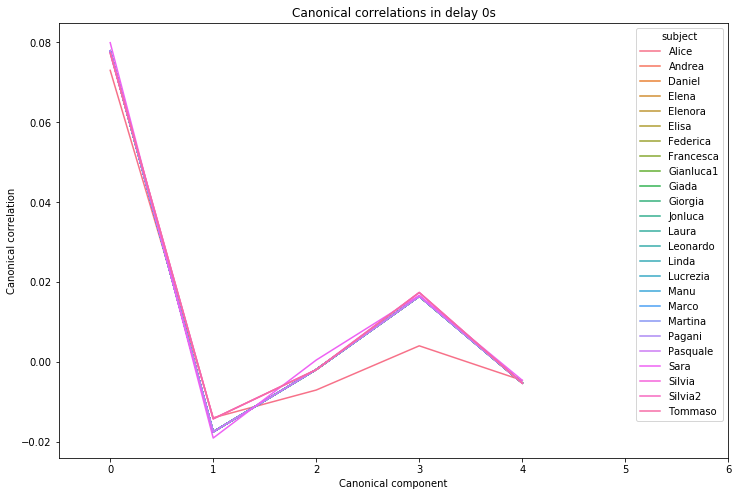

In [53]:
# plot all components and all subjects correlation score at delay
plotAllComp(data_plot,D)
plt.title('Canonical correlations in delay '+str(D) +'s')


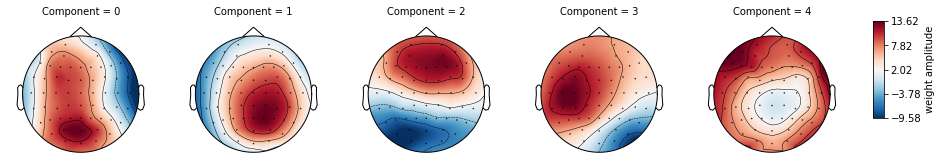

In [59]:
# plot all components topo at one delay
A,Vmin,Vmax=plotCCA_topo(data_plot,S,D)
plot_topo_image(A,Vmin,Vmax,'Component') 
#plt.title(subject_name[S])

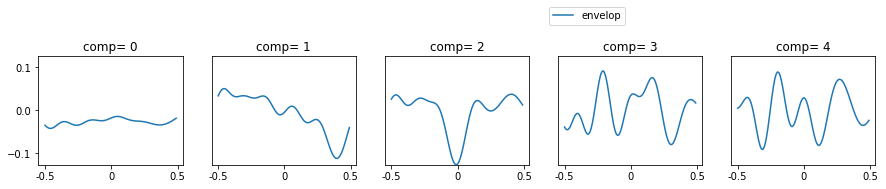

In [60]:
# plot component filter
plotComp_filter(data_plot,S,D)
#plt.title(subject_name[S])


In [ ]:
delay = np.arange(-5,5.5,0.5) / 10
# plot all components topo at one delay
for d in delay:
    A,Vmin,Vmax=plotCCA_topo(data_plot,S,d)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
delay = np.arange(-5,5.5,0.5) / 10
delay = np.arange(-5,6) / 10

# plot component filter
for d in delay:
    plotComp_filter(data_plot,S,d)
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
# plot all subjects topo at one delay
for s in range(0,len(subject_name)):
    A,Vmin,Vmax=plotCCA_topo(data_plot,s,D)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[s])

In [ ]:
# plot all subjects topo at one delay
frame=[]
for s in range(0,len(subject_name)):
    A,Vmin,Vmax=plotCCA_topo(data_plot,s,D)
    frame.append(A)
    
A=pd.concat((frame),axis=0)
fg = sns.FacetGrid(A,col='Component',row='subject',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')

In [ ]:
# explore temporal filters sperately
b = data_plot[(data_plot['subject']==subject_name[S]) & (data_plot['Delay']==D)]
A = []
for i in range(0,nComp):
    a = b['Component'+str(i)+'_filters'].get_values()[0][0]
    for f in range(0,len(features)):
        for j in range(0,a.shape[0]):
            df = pd.DataFrame({'Feature':features[f],'Component':i,'time':[tvec[j]],
                               'Data':a[:,f][j]})
            A.append(df)    
temporal_filters = pd.concat((A),axis=0)

fg = sns.FacetGrid(temporal_filters,col='Component',row='Feature',margin_titles=True)
b = fg.map_dataframe(sns.lineplot, 'time','Data')

C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


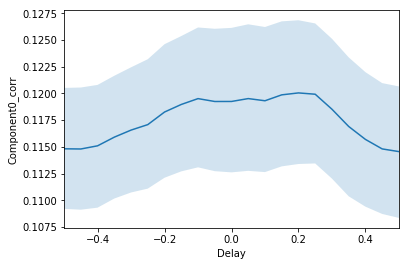

In [34]:
# plot 1 componet in all dealy avg subjects
comp = 0
plotComp_delay(data_plot,comp)

# yannis CCA imlementation in matlab (for comparisons)

In [ ]:
# load data from matlab
frame = []

for s in range(0,len(subject_name)):
    for d in delay:
        if(d==0.0):
            d=0
        raw_fname = data_path + '/python/matlab_CCA/cca/cca_delay_'+str(d)+'_'+subject_name[s]+'.mat'
        mat = scipy.io.loadmat(raw_fname)

        forwards = mat['forwards']
        filters = mat['filters']
        rhos = mat['rhos']
        for i in range(0,nComp):
            b = np.split(filters[:-1,i],6)
            b = np.vstack(b)

            a = forwards[:,i]
            a = pd.DataFrame({'subject':subject_name[s],'Delay':d,'Component':i,'Data':[a],
                              'corr':rhos[i],'filter':[b.T]})
            frame.append(a)

    

data_plot_matlab = pd.concat((frame),axis=0)
    
data_plot_matlab.head()

In [ ]:
# data vis function only for yannis matlab

# plot all components topo at all delay
def plotCCA_topo2(data_plot_matlab,s,d):
    B = data_plot_matlab[data_plot_matlab['subject']==subject_name[s]]

    frame = []
    for i in range(0,nComp):
        df = B[(B['Delay']==d) & (B['Component']==i)]['Data'].get_values()
        a = np.stack(df).mean(axis=0)
        a = pd.DataFrame({'Component':i,'Data':[a]})
        frame.append(a)

    A = pd.concat((frame),axis=0)

    Vmin = np.stack(A['Data'].get_values()).min()
    Vmax = np.stack(A['Data'].get_values()).max()
    
    return A,Vmin,Vmax

# plot component filter
def plotComp_filter2(data_plot_matlab,s,d):
    B = data_plot_matlab[data_plot_matlab['subject']==subject_name[s]]
    A = []
    for i in range(0,nComp):
        a = B[(B['Delay']==d) & (B['Component']==i)]['filter'].get_values()[0]        
        A.append(a)    
    A = np.stack(A)
    
    if(abs(A.min())<abs(A.max())):
        aa = abs(A.max())
    else:
        aa = abs(A.min())
            
    f, ax = plt.subplots(figsize=(15,2))
    for i in range(0,nComp):
        a = A[i,:,:]
        axx=plt.subplot(1,nComp,i+1)
        plt.plot(a)
        plt.title('comp= '+str(i))
        plt.ylim([-0.022,0.022])
        axx.set_xticklabels([0.1,-0.5,0,0.5])
        if not(i==0):
            plt.yticks([])        
    
    plt.legend(np.arange(1,7),loc='upper center', bbox_to_anchor=(0, 1.5),ncol=6)
    


In [ ]:
plotComp_filter2(data_plot_matlab,S,D)


In [ ]:

delay = np.arange(-5,5.5,0.5) / 10
# plot all components topo at one delay
for d in delay:
    A,Vmin,Vmax=plotCCA_topo2(data_plot_matlab,S,d)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
delay = np.arange(-5,5.5,0.5) / 10
delay = np.arange(-5,6) / 10
# plot component filter
for d in delay:
    plotComp_filter2(data_plot_matlab,S,d)
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
# plot all subjects topo at one delay
for s in range(0,len(subject_name)):
    A,Vmin,Vmax=plotCCA_topo2(data_plot_matlab,s,D)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[s])

In [ ]:
# plot all components topo at 0 delay
A = data_plot_matlab[data_plot_matlab['subject']==subject_name[S]]


a=[]
for i in range(0,nComp):
    a.append([A['Data'].get_values()[D].max(),A['Data'].get_values()[D].min()])

a=np.asarray(a)
VVmax = np.max(a[:,0])
VVmin = np.min(a[:,1])

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mne.viz.plot_topomap(x, info.info, show=False,vmin=VVmin,vmax=VVmax,cmap='RdBu_r')

def plot_topo_image(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='weight amplitude')
    
plot_topo_image(A,VVmin,VVmax,'Component') 


# plot component filter
B = data_plot_matlab[data_plot_matlab['subject']==subject_name[S]]
df = B[(B['Delay']==D)]


A = []
for i in range(0,nComp):
    a = df['filter'].get_values()[i]
    A.append(a)    
A = np.stack(A)

if(abs(A.min())<abs(A.max())):
    aa = abs(A.max())
else:
    aa = abs(A.min())

f, ax = plt.subplots(figsize=(15,2))
for i in range(0,nComp):
    a = A[i,:,:]
    axx=plt.subplot(1,nComp,i+1)
    plt.plot(a)
    plt.title('comp= '+str(i))
    plt.ylim([-aa,aa])
    axx.set_xticklabels([0.1,-0.5,0,0.5])
    if not(i==0):
        plt.yticks([])        

plt.legend(np.arange(1,7),loc='upper center', bbox_to_anchor=(0, 1.5),ncol=6)






# componet plot
f, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x='Component',y='corr',data=data_plot_matlab,hue='subject')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

